In [52]:
import json
import pymysql
import datetime
import feedparser
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pprint as pprint
import matplotlib.pyplot as plt 
import newsite_db_class as db_conn

from os import path
from PIL import Image
from bs4 import BeautifulSoup  
from wordcloud import WordCloud, STOPWORDS

# encoding: utf-8
%matplotlib inline

f = '%Y-%m-%d %H:%M:%S'
#now = datetime.datetime.now()
#now.strftime(f) 

In [53]:
with open('news_feed_dict.json', 'r') as fp:
    news_feed_dict = json.load(fp)

In [54]:
# from https://stackoverflow.com/questions/6327146/how-to-find-rss-feed-of-a-particular-website
def get_rss_feed(website_url):
    if website_url is None:
        print("URL should not be null")
    else:
        source_code = requests.get(website_url)
        plain_text = source_code.text
        soup = BeautifulSoup(plain_text)
        for link in soup.find_all("link", {"type" : "application/rss+xml"}):
            href = link.get('href')
            print("RSS feed for " + website_url + "is -->" + str(href))
            return 
        print("Nothing found")
# get_rss_feed("http://www.breitbart.com/") 

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

# fill database with source reference
def fill_source_table_DB():
    DB_instance = db_conn.databaseInterface()
    
    for politics in news_feed_dict.keys():
        for name in news_feed_dict[politics]:
            sql_info = [politics,
                        news_feed_dict[politics][name]["url"],
                        name,
                        news_feed_dict[politics][name]["feed_url"]
                       ]
            DB_instance.insert_into_sources(sql_info)
    return True

def add_headlineText_to_DB(rss_feed_list,DB_instance):
    for site in rss_feed_list:
        #print(site)
        d = feedparser.parse(site)
        now = datetime.datetime.now()
        time_to_enter = now.strftime(f)

        for k in range(len(d.entries)):
            title_text = d.entries[k]['title']
            summary_text = d.entries[k]['summary']
            summary_text = summary_text.encode()

            sql_info = [time_to_enter,
                        title_text,
                        summary_text,
                        str(site)]

            DB_instance.insert_into_source_data(sql_info)
        

# top conservative news websites
http://thefederalistpapers.org/top-100-conservative-websites-by-global-alexa-rating-second-quarter-2014

Top 100 Conservative Websites by Global Alexa Rating
Rank	Name	Website	Alexa No Q2’14
1	Fox News	http://www.foxnews.com/	176
2	WSJ Opinion Journal https://www.wsj.com/	http://online.wsj.com/public/page/news-opinion-commentary.html	241
3	Drudge Report	http://www.drudgereport.com/	452
4	The Blaze	http://www.theblaze.com/	556
5	New York Post	http://nypost.com/	873
6	Breitbart	http://www.breitbart.com/	1,339
7	IJ Review	http://www.ijreview.com/	1,749
8	NewsMax	http://newsmax.com/	1,824
9	WND	http://www.wnd.com/	2,100
10	Daily Caller	http://dailycaller.com/	2,166
11	Washington Times	http://www.washingtontimes.com/	2,337
12	National Review Online	http://www.nationalreview.com/	4,461
13	TownHall	http://townhall.com/	4,965
14	Free Republic	http://www.freerepublic.com/	5,232
15	Instapundit/Pajamas Media	http://pjmedia.com/instapundit/	5,486

# top liberal websites
1 Nytimes
2 huffingtonpost
3 washingtonpost
4 cnn
5 abcnews
6 rollingstone
7 time
8 slate
9 politico
10 the daily beast
11 salon
12 nbcnews
13 the atlantic
14 the newyorker
15 dailykos


In [55]:
test_feeds = []
conservative_rss_feeds = [str(news_feed_dict['C'][key]['feed_url']) for key in news_feed_dict['C'].keys()]
liberal_rss_feeds = [str(news_feed_dict['L'][key]['feed_url']) for key in news_feed_dict['L'].keys()]
russia_today = ['https://www.rt.com/rss/']     

In [56]:
# fill another snapshot of headlines and summaries for all sites
DB_instance = db_conn.databaseInterface()
feed_lists = [conservative_rss_feeds,liberal_rss_feeds,russia_today]
#with DB_instance.connection.cursor() as cursor:
for feed_list in feed_lists:
    add_headlineText_to_DB(feed_list,DB_instance)


In [14]:
site

'http://feeds.foxnews.com/foxnews/most-popular'

In [21]:
with DB_instance.connection.cursor() as cursor:
    # Create a new record
    sql = "(select source_id from sources where rss_feed_url = 'http://feeds.feedburner.com/breitbart')" 
    cursor.execute(sql)
    result = cursor.fetchone()

    d = feedparser.parse('http://feeds.feedburner.com/breitbart')
    now = datetime.datetime.now()
    time_to_enter = now.strftime(f)
    
    title_text = d.entries[0]['title']
    summary_text = d.entries[0]['summary']
    summary_text = summary_text.encode()
    
    sql_info = [time_to_enter,title_text,summary_text,str('http://feeds.feedburner.com/breitbart')]
    sql = "INSERT INTO `source_data` (`date`, `title`,`summary`,`source_id`) VALUES (%s, %s, %s, %s)"
    cursor.execute(sql,
      (sql_info[0],
      sql_info[1],
      sql_info[2],
      result['source_id']))
    

In [23]:
time_to_enter

'2017-06-22 13:18:32'

In [25]:

# print("Conservative:\n")
# for site in conservative_rss_feeds:
#     print(site)
#     d = feedparser.parse(site)
#     now = datetime.datetime.now()
#     time_to_enter = now.strftime(f)
#     title_text = d.entries[0]['title']
#     summary_text = d.entries[0]['summary']
#     sql_info = [time_to_enter,
#                 title_text,
#                 summary_text,
#                 str(site)]
#     sql = "(select source_id from sources where rss_feed_url = '%s')" %str(site)
#     print(sql)
#     DB_instance.insert_into_source_data(sql_info)
#     print(d.entries[0]['title'])
#     print(d.entries[0]['summary'])
    
# print("\nLiberal:\n")
# for site in liberal_rss_feeds:
#     d = feedparser.parse(site)
#     print(d.entries[0]['title'] )

In [10]:
# harlem gun boy
#http://www.foxnews.com/us/2017/01/12/police-boy-pulls-gun-on-classmate-demands-chicken-mcnugget.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+foxnews%2Fnational+(Internal+-+US+Latest+-+Text)

In [12]:
# make word clouds
# there must be a better way to do this with dictionaries :(
print("Conservative:\n")
cons_words = open('headline_data/cons_words'+str(datetime.datetime.now()).replace(" ", "")+'.txt','a')
for site in news_feed_dict['C'].keys():
    url = news_feed_dict['C'][site]['feed_url']
    d = feedparser.parse(url)
    words = []
    for entry in d.entries:
        cons_words.write(entry['title'])
        cons_words.write(' ')
        words.append(entry['title'])
    news_feed_dict['C'][site]['headlines'] = words

cons_words.close()

print("Liberal:\n")
liberal_words = open('headline_data/liberal_words'+str(datetime.datetime.now()).replace(" ", "")+'.txt','a')
for site in news_feed_dict['L'].keys():
    url = news_feed_dict['L'][site]['feed_url']
    d = feedparser.parse(url)
    words = []
    for entry in d.entries:
        liberal_words.write(entry['title'])
        liberal_words.write(' ')
        words.append(entry['title'])
    news_feed_dict['L'][site]['headlines'] = words
liberal_words.close()

print("Russia_today")
russia_words = open('headline_data/RT_words'+str(datetime.datetime.now()).replace(" ", "")+'.txt','a')
d = feedparser.parse(russia_today[0])
words = []
for entry in d.entries:
    russia_words.write(entry['title'])
    russia_words.write(' ')
    words.append(entry['title'])
news_feed_dict['O']['russia_today']['headlines'] = words
russia_words.close()

Conservative:

Liberal:

Russia_today


# Wordclouds

In [8]:
from wordcloud import WordCloud

In [9]:
text = open('headline_data/cons_words2017-05-2521:40:51.988794.txt').read()
text = text.replace("VIDEO","")
text = text.replace("PHOTOS","")

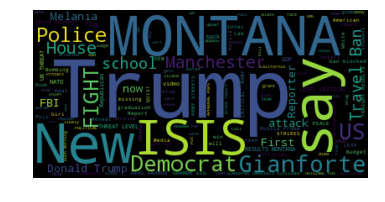

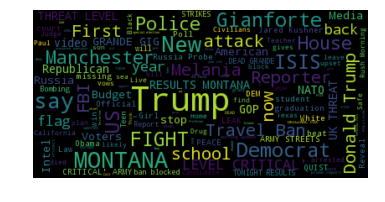

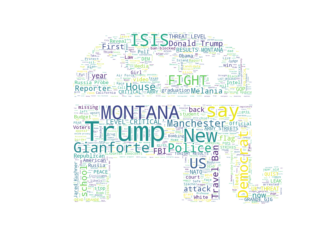

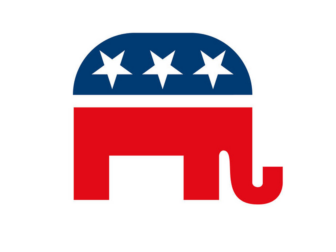

In [10]:
# Generate a word cloud image
wordcloud = WordCloud().generate(text)
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

GOP_mask = np.array(Image.open("republican-elephant.jpg"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=GOP_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file("GOP_word_cloud.png")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(GOP_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

# Analysis

In [18]:
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re

In [13]:
def preprocess(filename):
    text = open(filename).read()
    text = text.replace("VIDEO","")
    text = text.replace("‘","'")
    text = text.replace("PHOTOS","")
    
    # get rid of common contractions
    for words in text.split():
        if words in contractions.keys():
            text = text.replace(words,contractions[words].split("/")[0])
            print(words)
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    wordsFiltered = []

    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    for i,word in enumerate(wordsFiltered):
        if "'s" in word:
            wordsFiltered[i] = word.split("'s")[0]
            
    #new_list = [word for word in wordsFiltered if word not "\'s"]
    
    return " ".join(wordsFiltered)

In [14]:
filename = 'headline_data/cons_words2017-05-2610:54:48.060819.txt'
text = preprocess(filename)

# tokenization
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(text)

text_nltk = nltk.Text(tokens)
text_nltk.collocations()

don't
fight montana; coptic christians; special election; level critical;
threat level; tonight results; army streets; montana gianforte;
approval pops; bike lock; morning update; pleads guilty; travel ban;
critical army; last original; original fox; greg gianforte; results
montana; anxiety fades; britain resumes


In [15]:
fdist1 = nltk.FreqDist(text_nltk)
fdist1.most_common(34)

[('trump', 41),
 ('montana', 25),
 ('gianforte', 20),
 ('s', 13),
 ('quist', 12),
 ('fight', 11),
 ('christians', 10),
 ('first', 10),
 ('uk', 8),
 ('attack', 8),
 ('coptic', 7),
 ('critical', 6),
 ('manchester', 6),
 ('report', 6),
 ('house', 6),
 ('melania', 6),
 ('news', 6),
 ('arrested', 6),
 ('threat', 6),
 ('44', 5),
 ('election', 5),
 ('nato', 5),
 ('back', 5),
 ('russia', 5),
 ('51', 5),
 ('says', 5),
 ('speech', 5),
 ('special', 5),
 ('police', 5),
 ('7', 5),
 ('teen', 5),
 ('egypt', 5),
 ('democrats', 5),
 ('professor', 5)]